# Introduction
According to [Wikipedia](https://en.wikipedia.org/wiki/Bode_plot),
> A Bode plot /ˈboʊdi/ is a graph of the frequency response of a system. It is usually a combination of a Bode magnitude plot, expressing the magnitude (usually in decibels) of the frequency response, and a Bode phase plot, expressing the phase shift.

**Note**: The code is not specific to RC, you can actually use it for other type of circuits & systems.

# Connection
![Breadboard](../extra/img/fritzing/Bode Plot RC_bb.png)
The above is a [RC circuit](https://en.wikipedia.org/wiki/RC_circuit)

![Real](../extra/img/bode-plot-rc.jpg)

In the circuit, Capacitor = $0.1\mu F$ and Resistance = $550\Omega$.  
Using the formula of Cut-off frequency, $f = \frac 1 {2\pi \dot RC}$.  
That gives us, $f = \frac 1 {0.000345} = 2.89KHz$

<IPython.core.display.Javascript object>


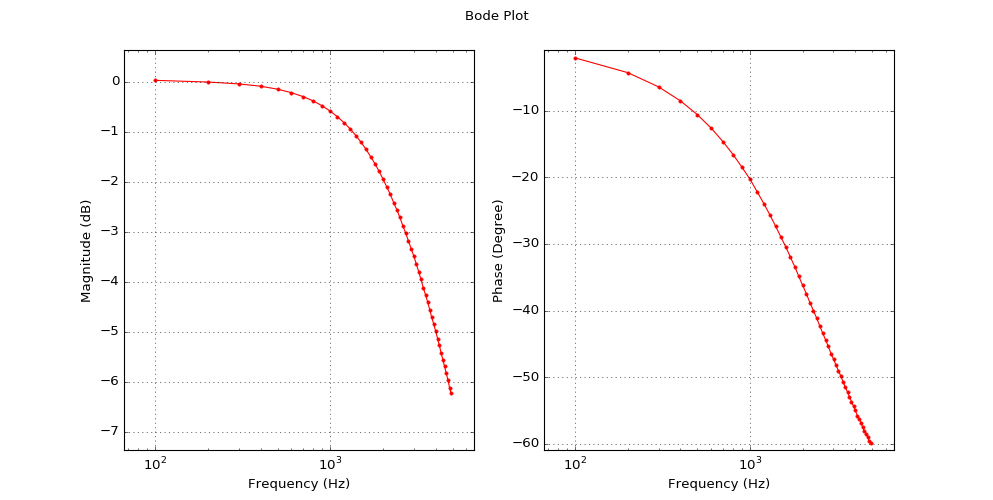

In [3]:
#~ %matplotlib notebook
import box0
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import math

# allocated resources
dev = box0.usb.open_supported()
ain0 = dev.ain(0)
aout0 = dev.aout(0)

# prepare resources

ain0.snapshot_prepare()
ain0.chan_seq_set([0, 1])

aout0.snapshot_prepare()
aout0.chan_seq_set([0])

FREQ = range(100, 5000, 100)

REF_LOW = -3.3
REF_HIGH = 3.3
INPUT_AMPLITUDE = (REF_HIGH - REF_LOW) / 2

data_freq = []
data_phase = []
data_magnitude = []

def set_freq(freq):
    """
    Set frequency to AOUT0.CH0
    :param float freq: Requested frequency
    :return: Actual frequency
    """
    global aout0

    # try to stop aout0 from last run
    try: aout0.snapshot_stop()
    except: pass

    # calculate the actual frequency that can be generated
    count, speed = aout0.snapshot_calc(freq, 12)
    freq = float(speed) / float(count)

    # generate a sine wave
    x = np.linspace(-np.pi, +np.pi, count)
    y = np.sin(x) * INPUT_AMPLITUDE

    # set the configuration to module
    aout0.bitsize_speed_set(12, speed)
    aout0.snapshot_start(y)

    return freq

def get_best_speed_and_count(freq):
    """
    Find the best sampling frequency at which signal with `freq` can be captured.
    Care is taken to not exceed more than 100ms acquisition duration.
    :param float freq: Frequency of expected signal that need to be captured
    :return: sampling_freq, count
    :rtype: int, int
    """
    sampling_freq = freq * 40 # atleast sample 40 time more than the signal frequency
    max_sample_count = 1000
    max_duration = 0.1 # 100ms

    sample_count = min(max_duration * sampling_freq, max_sample_count)

    # make sample_count multiple of 2, because two channel are being captured
    sample_count = int(sample_count / 2) * 2

    return int(sampling_freq), int(sample_count)

# ref: http://stackoverflow.com/a/26512495/1500988
def curve_fit_sine(t, y, freq):
    """Perform curve fitting of sine data"""
    p0 = (INPUT_AMPLITUDE, 0.0, 0.0)
    p_lo = (0.0, -np.pi, 0.0)
    p_up = (INPUT_AMPLITUDE, np.pi, REF_HIGH)

    def cb(t, amplitude, phase, offset):
        return np.sin(2 * np.pi * t * freq + phase) * amplitude + offset

    fit = curve_fit(cb, t, y, p0=p0, bounds=(p_lo, p_up))
    fit = fit[0]

    return fit[0], math.degrees(fit[1])

def get_data(freq):
    """
    Get channel data of ain0.
    :param float freq: expected Frequency of the signal that need to be captured
    :return: magnitude_in_db, phase_in_degree
    """
    global ain0

    # retrive data
    sampling_freq, sample_count = get_best_speed_and_count(freq)
    ain0.bitsize_speed_set(12, sampling_freq)
    data = np.empty(sample_count)
    ain0.snapshot_start(data)

    # process the data
    t = np.linspace(0.0, float(sample_count) / sampling_freq, sample_count, endpoint=False)
    input_amplitude, input_phase = curve_fit_sine(t[0::2], data[0::2], freq)
    output_amplitude, output_phase = curve_fit_sine(t[1::2], data[1::2], freq)

    # extract results
    magnitude = 20 * math.log10(output_amplitude / input_amplitude)
    phase = (output_phase - input_phase) % 360

    # convert phase into a value that is around 0
    if phase < -180:
        phase += 360
    elif phase > 180:
        phase -= 360

    return magnitude, phase

for freq in FREQ:
    #print("capturing ", freq)

    # do the main part!
    freq = set_freq(freq)
    magnitude, phase = get_data(freq)

    # store the results
    data_freq.append(freq)
    data_magnitude.append(magnitude)
    data_phase.append(phase)

# free up resources
ain0.close()
aout0.close()
dev.close()

fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True)
fig.suptitle("Bode Plot")

magnitude = axs[0]
magnitude.grid(True)
magnitude.set_xscale('log')
#magnitude.set_yscale('log')
magnitude.set_xlabel("Frequency (Hz)")
magnitude.set_ylabel("Magnitude (dB)")
magnitude.plot(data_freq, data_magnitude, 'r.-')

phase = axs[1]
phase.grid(True)
phase.set_xscale('log')
phase.set_xlabel("Frequency (Hz)")
phase.set_ylabel("Phase (Degree)")
phase.plot(data_freq, data_phase, 'r.-')

# Show the data
plt.show()